# 数量化理論をPythonで理解する

数量化理論とは、数値ではない「カテゴリカルデータ」と呼ばれるデータをいかに統計学の世界に招き入れるかという理論で、数量化I類、数量化II類などが有名です。

### 数量化I類・拡張型数量化I類

重回帰分析などの回帰分析は、数値データを説明変数とし、数値データを目的変数として予測します。一方で、数値ではないカテゴリカルデータを説明変数とし、数値データを目的変数として予測するのが数量化I類です。説明変数に数値データとカテゴリカルが混在している場合は拡張型数量化I類と呼ばれます。

### 数量化II類・拡張型数量化II類

ロジスティック回帰や判別分析などは、数値データを説明変数とし、カテゴリカルデータを目的変数として予測するのに使われます。一方で、数値ではないカテゴリカルデータを説明変数とし、数値データを目的変数として予測するのが数量化II類です。説明変数に数値データとカテゴリカルデータが混在している場合は拡張型数量化II類と呼ばれます。

# １９８５年自動車価格のデータを例に説明します。

UCI Machine Learning Repository の Automobile のデータ http://archive.ics.uci.edu/ml/datasets/Automobile を少し改変したものを利用します。

In [1]:
# URL によるリソースへのアクセスを提供するライブラリをインポートする
import urllib.request 

# URLを指定してテキストデータをダウンロードする
url = "https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/auto-imports-1985.txt"
urllib.request.urlretrieve(url, 'auto-imports-1985.txt') 

('auto-imports-1985.txt', <http.client.HTTPMessage at 0x10876e6a0>)

In [2]:
# 表形式の計算をサポートするライブラリのインポート
import pandas as pd

# ダウンロードしたデータを読み込む
df = pd.read_csv("auto-imports-1985.txt", sep="\t", index_col=0)
df.head()

# 実は、次のように直接URLを指定しても読み込めるが、
# 当然、そのときインターネットに接続していなければいけません
# df = pd.read_csv("https://raw.githubusercontent.com/maskot1977/ipython_notebook/master/toydata/auto-imports-1985.txt", sep="\t", index_col=0)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


数字のデータと、数字ではないデータ（カテゴリカルデータ）が混在してますね。

# データの前処理

## 説明変数Xと目的変数Yに分解

説明変数Xと目的変数Yに分解しましょう。この説明変数Xから目的変数Yを予測することを目指します。

In [3]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [4]:
# 説明変数
X.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22


In [5]:
# 目的変数
pd.DataFrame(Y).head()

,price
0,13495.0
1,16500.0
2,16500.0
3,13950.0
4,17450.0


## カテゴリカルデータをダミー変数に変換

pandas.get_dummies() を用いて、カテゴリカルデータをダミー変数に変換します。ダミー変数とは、そのカテゴリーに属すれば１、属さなければ０の変数です。dummy_na=True を指定すると、データが NaN（欠損値） の場合に１、欠損でなければ０とします。

重回帰分析などでは、カテゴリーの数がN個ある場合、N個のダミー変数を作ると予測できないため、どれか1個の変数を除外します。scikit-learnの重回帰分析 LinearRegression() では、この問題を回避する設計にしているようで、N個のダミー変数を作成しても動作します。

なお、pandas.get_dummies(drop_first=True) とすると、ダミー変数を作成するときに最初のカテゴリーを無視します。 

In [6]:
X = pd.get_dummies(X, dummy_na=True)
X.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,...,num-of-cylinders_nan,fuel-system_1bbl,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi,fuel-system_nan
0,3,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,1,0,0,0
1,3,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,1,0,0,0
2,1,NaN,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,...,0,0,0,0,0,0,1,0,0,0
3,2,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,...,0,0,0,0,0,0,1,0,0,0
4,2,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,...,0,0,0,0,0,0,1,0,0,0


## 数値データの欠損値を補間

pandas.get_dummies() では、カテゴリカルデータの欠損値は欠損値という値に変換しますが、数値データの欠損値は保管されません。補間する方法として pandas.DataFrame.fillna() があります。詳しくは pd.DataFrame.fillna? と入力して調べてみてください。

なお、欠損値を補間するのではなく、欠損値のあるデータを取り除きたい場合は pd.DataFrame.dropna() とします。

In [7]:
X = X.fillna(X.median())
X.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,...,num-of-cylinders_nan,fuel-system_1bbl,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi,fuel-system_nan
0,3,115.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,1,0,0,0
1,3,115.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,1,0,0,0
2,1,115.0,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,...,0,0,0,0,0,0,1,0,0,0
3,2,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,...,0,0,0,0,0,0,1,0,0,0
4,2,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,...,0,0,0,0,0,0,1,0,0,0


## 分散値がゼロの列を取り除く

分散値がゼロの列は予測に使えません。以下のようにして取り除きます。列の数の変化を確認してください。

In [8]:
X = X.iloc[:, [i for i, x in enumerate(X.var()) if x != 0]]
X.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,...,num-of-cylinders_twelve,num-of-cylinders_two,fuel-system_1bbl,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,3,115.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
1,3,115.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
2,1,115.0,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,...,0,0,0,0,0,0,0,1,0,0
3,2,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0
4,2,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0


## サンプル数が１のカテゴリカルデータを取り除く

サンプル数がゼロのカテゴリカルデータは予測に使えません。以下のようにして取り除きます。列の数の変化を確認してください。

In [9]:
X = X.iloc[:, [i for i, x in enumerate(X.sum()) if x != 1]]
X.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,...,num-of-cylinders_five,num-of-cylinders_four,num-of-cylinders_six,num-of-cylinders_two,fuel-system_1bbl,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mpfi,fuel-system_spdi
0,3,115.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,1,0,0,0,0,0,0,1,0
1,3,115.0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,...,0,1,0,0,0,0,0,0,1,0
2,1,115.0,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,...,0,0,1,0,0,0,0,0,1,0
3,2,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,...,0,1,0,0,0,0,0,0,1,0
4,2,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,...,1,0,0,0,0,0,0,0,1,0


## エラーを起こす行を除外

以上で、エラーを起こしそうな原因はできるだけ取り除いたつもりですが、実際にはそれでもなぜかエラーを起こす行が残っていたりします。そのような場合、１行ずつ加えながら解析を実行し、エラーを起こす行を特定しながら取り除いていきます。

In [10]:
from sklearn import linear_model
safe = []
droplist = []
for i in range(len(X)):
    try:
        clf = linear_model.LinearRegression() # 重回帰分析
        clf.fit(X.iloc[safe + [i], :], Y.iloc[safe + [i]])
        safe.append(i)
    except:
        droplist.append(i)

/Users/kot/miniconda3/envs/py3new/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


上記のコードにより、エラーを起こさない列の番号を safe というリストに、エラーを起こす列の番号を droplist というリストに格納しました。droplist の中身は次のようになります。

In [11]:
droplist

[9, 44, 45, 129]

エラーを起こさない行を集めて、それをもとに説明変数Xと目的変数Yを作り直します。

In [12]:
X = X.iloc[safe, :]
Y = Y.iloc[safe]

# 機械学習と交差検定

ここまでくれば、あとは重回帰分析でも何でも来いです。以下のコードでは、１００回交差検定を行って、テストセットの予測精度を見積もっています。

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
result_scores = []
for _ in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
    clf = linear_model.LinearRegression()
    clf.fit(X_train, Y_train)
    result_scores.append(clf.score(X_test, Y_test))
print('{0:.4f} ± {1:.4f}'.format(np.mean(result_scores), np.std(result_scores)))

0.8382 ± 0.1194


# 結果の解釈

普通の重回帰分析においては、回帰係数は、目的変数を予測するときの傾きという解釈ができます。カテゴリカルデータを用いた場合はどうでしょうか。

In [14]:
clf = linear_model.LinearRegression()
clf.fit(X, Y)
coefs = pd.DataFrame(clf.coef_, index=X.columns).sort_values(0, ascending=False)
coefs # 回帰係数を大きい順に並べたもの

,0
make_bmw,10041.151756
make_porsche,7829.488014
make_audi,6605.635485
engine-type_l,6530.190701
make_saab,6380.589720
make_mercedes-benz,5948.369828
num-of-cylinders_eight,5893.599864
fuel-type_diesel,3607.600803
fuel-system_idi,3607.600803
make_alfa-romero,3410.184970


ひとつのカテゴリカルデータが複数の列に分れたままなので解釈が難しいですね。

## 同じカテゴリカルデータ由来の列をまとめる

ダミー変数の作成により、ひとつのカテゴリカルデータが複数の列に分かれます。この作業は重回帰分析などの手法を適用するために必要なのですが、列が分かれたままでは解釈が困難になるため、どのカテゴリカルデータがどの列に分れたのかが追跡できるようにします。

In [15]:
col_group = {}
for col in X.columns:
    a = col.split("_")
    if len(a) == 2:
        if a[0] not in col_group.keys():
            col_group[a[0]] = []
        col_group[a[0]].append(a[1])
    else:
        col_group[col] = [col]

このように分かれたことがわかります。

In [16]:
for k, v in col_group.items():
    print(k,":", v)

symboling : ['symboling']
normalized-losses : ['normalized-losses']
wheel-base : ['wheel-base']
length : ['length']
width : ['width']
height : ['height']
curb-weight : ['curb-weight']
engine-size : ['engine-size']
bore : ['bore']
stroke : ['stroke']
compression-ratio : ['compression-ratio']
horsepower : ['horsepower']
peak-rpm : ['peak-rpm']
city-mpg : ['city-mpg']
highway-mpg : ['highway-mpg']
make : ['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda', 'isuzu', 'jaguar', 'mazda', 'mercedes-benz', 'mitsubishi', 'nissan', 'peugot', 'plymouth', 'porsche', 'renault', 'saab', 'subaru', 'toyota', 'volkswagen', 'volvo']
fuel-type : ['diesel', 'gas']
aspiration : ['std', 'turbo']
num-of-doors : ['four', 'two', 'nan']
body-style : ['convertible', 'hardtop', 'hatchback', 'sedan', 'wagon']
drive-wheels : ['4wd', 'fwd', 'rwd']
engine-location : ['front', 'rear']
engine-type : ['dohc', 'l', 'ohc', 'ohcf', 'ohcv', 'rotor']
num-of-cylinders : ['eight', 'five', 'four', 'six', 'two']
fuel-sys

## 回帰係数の幅

もともと同じ列に存在していたデータの回帰係数をひとまとめにします。

In [17]:
names = []
values = []
for k,v in col_group.items():
    if len(v) == 1:
        coef = coefs.loc[k][0]
        names.append(k)
        values.append([coef])
    else:
        names.append(k)
        ary = []
        for val in v:
            coef = coefs.loc["{}_{}".format(k,val)][0]
            ary.append(coef)
        values.append(ary)

その標準回帰係数がどのくらいの幅を持っているのか図示してみましょう。

/Users/kot/miniconda3/envs/py3new/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


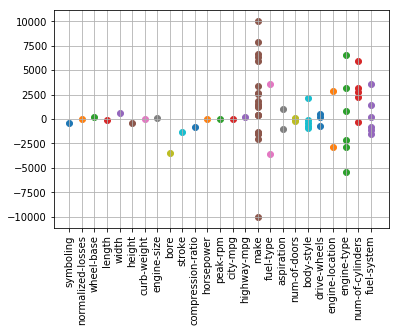

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, y in enumerate(values):
    plt.scatter([i for _ in y], y)
plt.xticks([i for i in range(len(names))], names, rotation=90)
plt.grid()
plt.show()

カテゴリカル変数の回帰係数が正負に大きい傾向がありますが、対応するダミー変数が０か１かしかない影響です。

## 相関係数との関係

次に、相関係数との関係を見てみましょう。ここで意識すべきことは、説明変数と目的変数が直線的な関係（線形）であるという前提条件において、

* 相関係数が 1 に近い説明変数は、価格を高くする要因である。
* 相関係数が -1 に近い説明変数は、価格を低くする要因である。
* 相関係数が 0 に近い説明変数は、価格にはあまり影響しない要因である。
* 相関係数の正負と、標準回帰係数の正負が一致しているものが、価格への影響が説明できる要因である。もし正負が逆転している場合は、価格への影響が（少なくとも線形関係としては）説明できない。

下記のコードでは、数値データの場合は横軸＝元データ、縦軸＝価格として散布図・相関係数・標準回帰係数を出力し、カテゴリカルデータの場合は横軸＝標準回帰係数、縦軸＝価格の平均値として散布図・相関係数を出力します。ひとつひとつの説明変数に対して、相関係数と標準回帰係数の関係を観察してください。

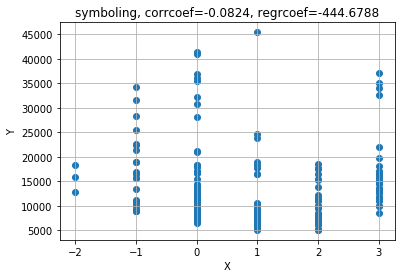

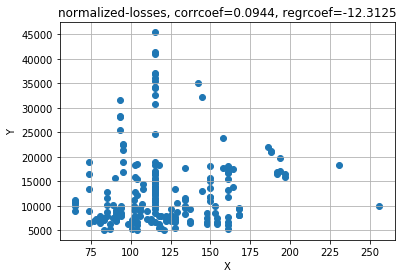

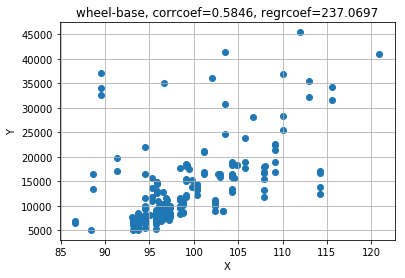

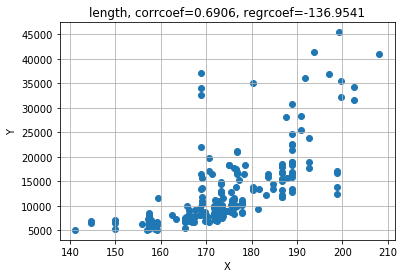

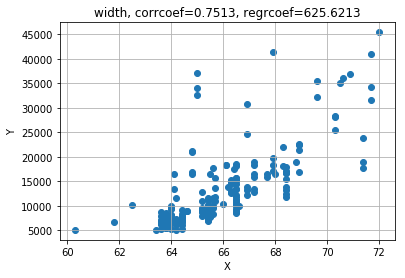

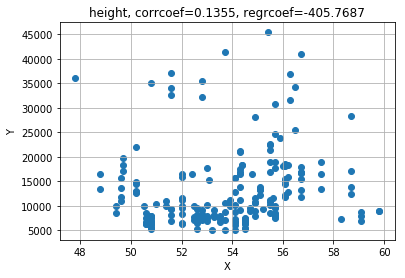

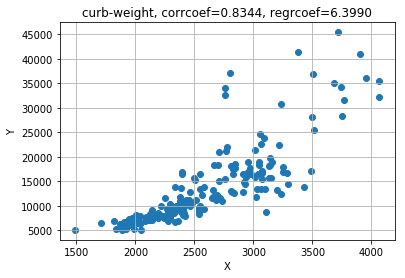

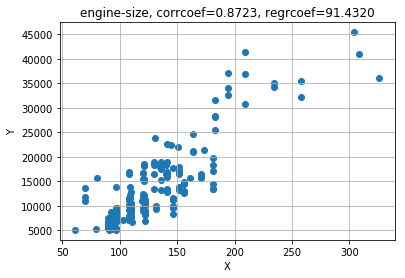

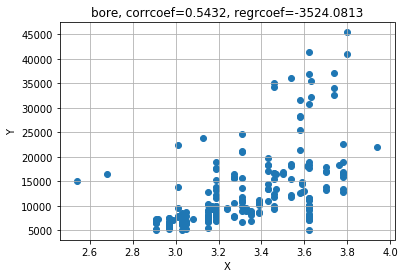

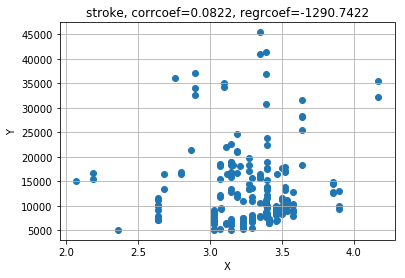

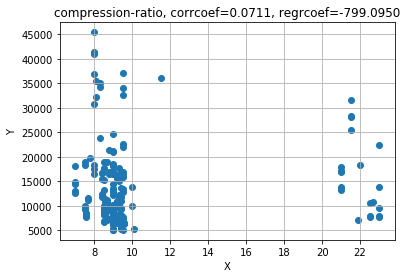

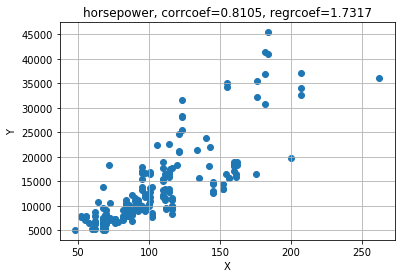

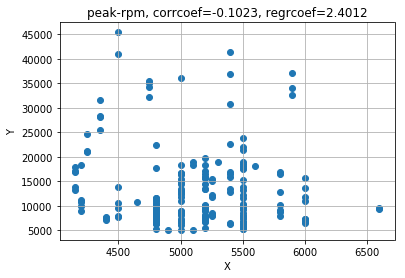

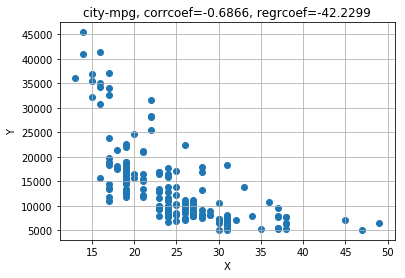

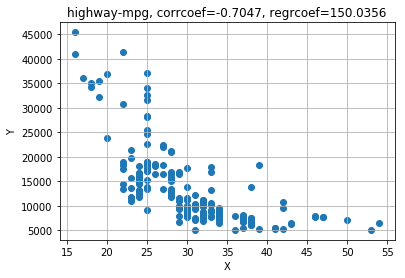

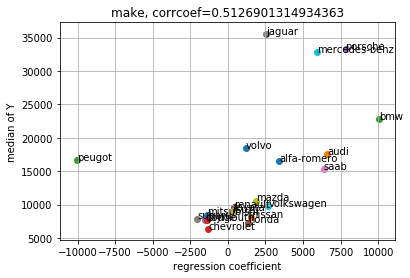

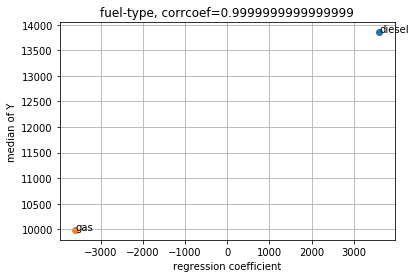

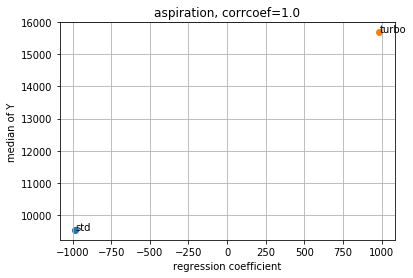

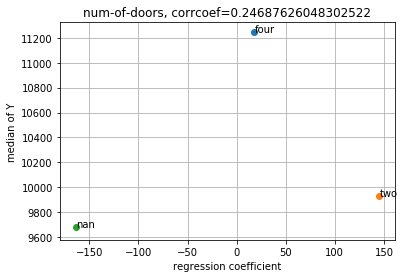

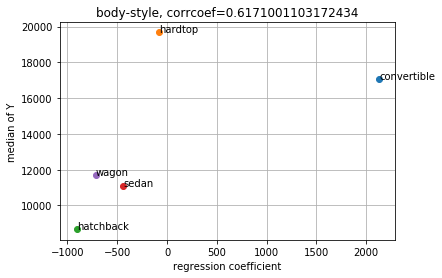

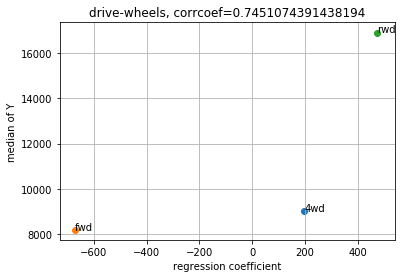

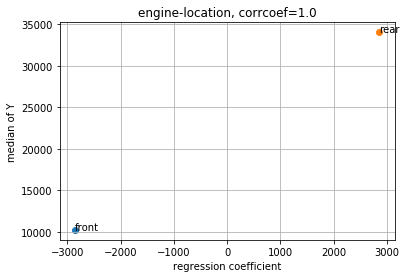

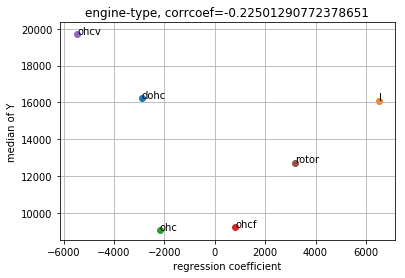

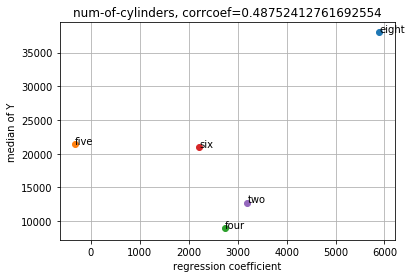

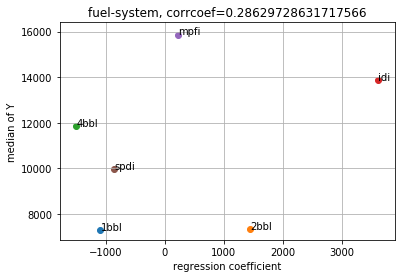

In [19]:
import numpy as np
meaningful_cols = []
for k,v in col_group.items():
    if len(v) != 1:
        x_axis = []
        y_axis = []
        xy_names = []
        for val in v:
            try:
                x_axis.append(coefs.loc["{}_{}".format(k,val)][0])
                y_axis.append(Y[X["{}_{}".format(k,val)] == 1].median())                   
                xy_names.append(val)
            except:
                continue
                
        corrcoef = np.corrcoef(x_axis, y_axis)[0][1]
        plt.title("{}, corrcoef={}".format(k, corrcoef))
        for x, y, name in zip(x_axis, y_axis, xy_names):
            plt.scatter(x, y)
            plt.text(x, y, name)
        plt.xlabel("regression coefficient")
        plt.ylabel("median of Y")
        plt.grid()
        plt.show()
        
        if np.corrcoef(x_axis, y_axis)[0][1] >= 0.5:
            meaningful_cols.append(k)
    else:
        corrcoef = np.corrcoef(X[k].values, Y.values)[0][1]
        regrcoef = coefs.loc[k][0]
        plt.title("{0}, corrcoef={1:.4f}, regrcoef={2:.4f}".format(k, corrcoef, regrcoef))
        plt.scatter(X[k].values, Y.values)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid()
        plt.show()
        if corrcoef * regrcoef > 0:
            if abs(np.corrcoef(X[k].values, Y.values)[0][1]) >= 0.5:
                meaningful_cols.append(k)

以上のコードでは、相関係数と回帰係数を比較して、「予測する上で意味がありそうな」列を取り出し、meaningful_cols というリストの中に入れるようにしました。結果として次の列が「意味がありそうな」列として選ばれました。どういう条件で取り出したかは上のコードを確認してください。

In [20]:
meaningful_cols

['wheel-base',
 'width',
 'curb-weight',
 'engine-size',
 'horsepower',
 'city-mpg',
 'make',
 'fuel-type',
 'aspiration',
 'body-style',
 'drive-wheels',
 'engine-location']

## 「意味がありそうな」列だけを用いて予測

意味がありそうな列だけを用いて、データの前処理からやり直します。

In [21]:
X = df[meaningful_cols]
X = pd.get_dummies(X, dummy_na=True)
X = X.fillna(X.median())
X = X.iloc[:, [i for i, x in enumerate(X.var()) if x != 0]]
X = X.iloc[:, [i for i, x in enumerate(X.sum()) if x != 1]]
Y = df.iloc[:, -1]

In [22]:
from sklearn import linear_model
safe = []
droplist = []
for i in range(len(X)):
    try:
        clf = linear_model.LinearRegression()
        clf.fit(X.iloc[safe + [i], :], Y.iloc[safe + [i]])
        safe.append(i)
    except:
        droplist.append(i)

In [23]:
X = X.iloc[safe, :]
Y = Y.iloc[safe]

In [24]:
from sklearn.model_selection import train_test_split
result_scores = []
for _ in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
    clf = linear_model.LinearRegression()
    clf.fit(X_train, Y_train)
    result_scores.append(clf.score(X_test, Y_test))
print('{0:.4f} ± {1:.4f}'.format(np.mean(result_scores), np.std(result_scores)))

0.8975 ± 0.0277


全ての列を用いた時よりも精度が上がりました。

## 説明変数の影響度

通常の重回帰分析でもそうですが、説明変数の標準化をしてから回帰すると、説明変数の尺度に依存しない標準回帰係数が得られ、説明変数の影響度を比較することができます。

In [25]:
X_std = X.apply(lambda x: (x-x.mean())/x.std(), axis=0) # 説明変数の標準化
X_std.head()

,wheel-base,width,curb-weight,engine-size,horsepower,city-mpg,make_alfa-romero,make_audi,make_bmw,make_chevrolet,...,body-style_convertible,body-style_hardtop,body-style_hatchback,body-style_sedan,body-style_wagon,drive-wheels_4wd,drive-wheels_fwd,drive-wheels_rwd,engine-location_front,engine-location_rear
0,-1.680910,-0.851335,-0.014821,0.075201,0.205661,-0.650624,8.103804,-0.174975,-0.203088,-0.122785,...,5.686678,-0.203088,-0.713256,-0.934951,-0.37595,-0.203088,-1.189375,1.292920,0.122785,-0.122785
1,-1.680910,-0.851335,-0.014821,0.075201,0.205661,-0.650624,8.103804,-0.174975,-0.203088,-0.122785,...,5.686678,-0.203088,-0.713256,-0.934951,-0.37595,-0.203088,-1.189375,1.292920,0.122785,-0.122785
2,-0.708334,-0.185134,0.516789,0.604724,1.356164,-0.961995,8.103804,-0.174975,-0.203088,-0.122785,...,-0.174975,-0.203088,1.395045,-0.934951,-0.37595,-0.203088,-1.189375,1.292920,0.122785,-0.122785
3,0.165335,0.147966,-0.422710,-0.430252,-0.035142,-0.183569,-0.122785,5.686678,-0.203088,-0.122785,...,-0.174975,-0.203088,-0.713256,1.064253,-0.37595,-0.203088,0.836595,-0.769595,0.122785,-0.122785
4,0.099398,0.243137,0.518722,0.219617,0.312685,-1.117680,-0.122785,5.686678,-0.203088,-0.122785,...,-0.174975,-0.203088,-0.713256,1.064253,-0.37595,4.899487,-1.189375,-0.769595,0.122785,-0.122785


In [26]:
Y_std = [(y - Y.mean())/Y.std() for y in Y] # 目的変数の標準化

In [27]:
clf = linear_model.LinearRegression()
clf.fit(X_std, Y_std)
coefs = pd.DataFrame(clf.coef_, index=X_std.columns).sort_values(0, ascending=False)
coefs # 回帰係数を大きい順に並べたもの

,0
make_bmw,0.284965
make_mercedes-benz,0.282663
horsepower,0.214117
curb-weight,0.164879
make_porsche,0.145504
engine-size,0.142839
width,0.136375
make_jaguar,0.136342
make_audi,0.113193
make_mazda,0.113180


In [28]:
col_group = {}
for col in X_std.columns:
    a = col.split("_")
    if len(a) == 2:
        if a[0] not in col_group.keys():
            col_group[a[0]] = []
        col_group[a[0]].append(a[1])
    else:
        col_group[col] = [col]

In [29]:
names = []
values = []
for k,v in col_group.items():
    if len(v) == 1:
        coef = coefs.loc[k][0]
        names.append(k)
        values.append([coef])
    else:
        names.append(k)
        ary = []
        for val in v:
            coef = coefs.loc["{}_{}".format(k,val)][0]
            ary.append(coef)
        values.append(ary)

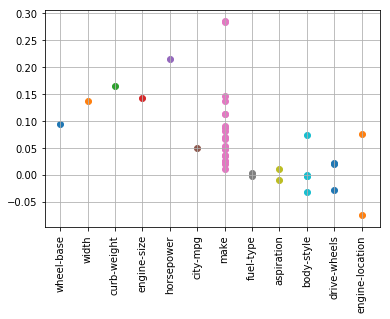

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, y in enumerate(values):
    plt.scatter([i for _ in y], y)
plt.xticks([i for i in range(len(names))], names, rotation=90)
plt.grid()
plt.show()

In [35]:
!osascript -e "beep"

In [36]:
!osascript -e 'tell application "Finder" to activate'

In [37]:
!osascript -e 'beep 2'

In [40]:
!osascript -e 'beep 3'

In [44]:
!osascript -e 'display dialog "終わったよ！"'

button returned:OK
